<a href="https://colab.research.google.com/github/tetsufmbio/workshop/blob/master/WORKSHOP_INOVA%C3%87%C3%83O_SA%C3%9ADE_IMD_Tetsu_Renata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizagem de máquina na predição de fatores genéticos relacionados a doença

**Por: Prof. Dr. Tetsu Sakamoto (BioME/IMD/UFRN) e Msc. Renata Cavalcante (BioME/IMD/UFRN)** 

---

## **Introdução**

Muitas vezes quando lidamos com problemas de classificação utilizando **métodos supervisionados** de aprendizado de máquina (prever uma variável dependente a partir de uma lista de variáveis independentes), temos em mãos dados que possuem **muitos atributos** (ou variáveis) para cada amostra. 

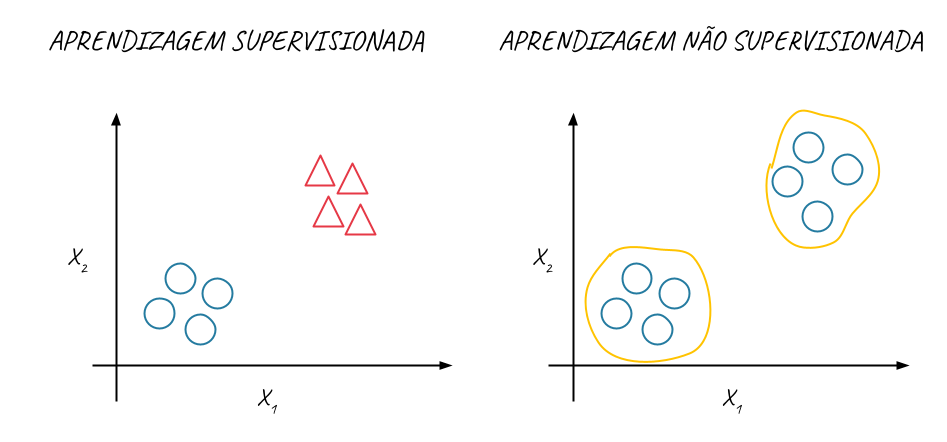



Exemplo disso são os dados de **expressão gênica**, onde para cada amostra é possível obter dados de expressão de centenas ou milhares de genes distintos. Neste caso, cada um dos genes pode servir como um atributo a ser considerado na construção de um modelo de aprendizado de máquina.

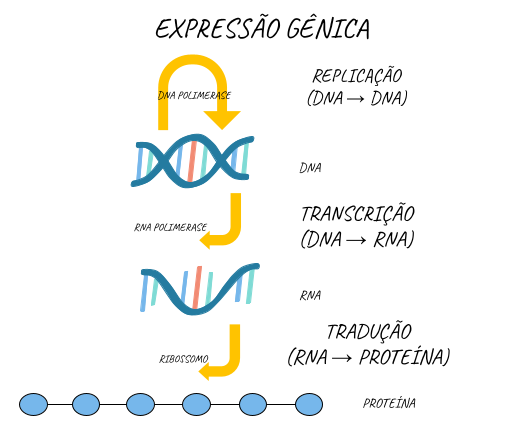

No entanto, o uso de muitos atributos pode incorrer a algumas desvantagens, como:

* A exigência de um tempo de processamento maior na etapa de treinamento do modelo;
* Redução da acurácia do modelo devido a presença de ruídos;

Por isso, antes de iniciar o treinamento do modelo propriamente dito, é interessante realizar passos de limpeza e de filtragem dos seus dados. A filtragem dos dados pode ser feita de forma a **selecionar** aqueles atributos que sejam importantes na construção do modelo. 

### Mas por que devemos selecionar atributos?



*   Dados faltantes
*   Quantidade de atributos
*   Colunas com alta correlação




A **seleção de atributos** nos permite responder outros tipos de questões sobre os nossos dados. Caso estejamos lidando com dados de expressão de pacientes sadios e doentes, podemos determinar quais genes são importantes ou fazem diferença na precisão e na acurácia de um modelo de aprendizado de máquina.

Este material abordará como podemos realizar na prática a **seleção de atributos** de um dado de expressão de câncer utilizando o Python.

## RNA-Seq

**RNA-seq** (abreviação de *RNA sequencing*) é uma técnica de sequenciamento de segunda geração (NGS), amplamente utilizada para analisar o perfis de **transcriptoma**.

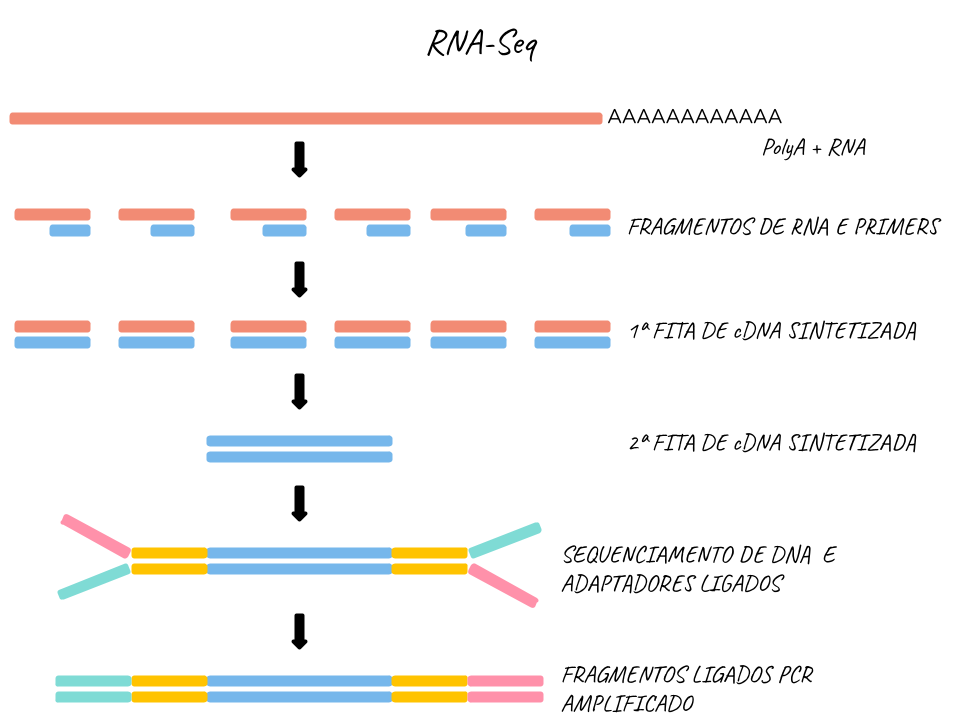

*   O **transcriptoma** nada mais é que o conjunto completo de transcritos (RNAs) em uma dada célula, tecido, órgão ou organismo. 

A análise de transcritomas por meio de RNA-seq nos permite comparar os nível de expressão de genes alvo em situações biológicas específicas, logo essa técnica auxilia na compreensão de diferentes mecanismos moleculares. 

## Carregando as bibliotecas necessárias


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Sobre os dados

Os dados que serão utilizados nesta aula são dados de expressão gênica de linfomas proveniente do artigo de [Shipp et al. (2002)](https://www.nature.com/articles/nm0102-68). Neste trabalho, foi verificado se é possível identificar dois tipos de linfoma (Linfoma difuso de células B grandes - DLBCL; e linfoma folicular - FL) utilizando dados de expressão gênica e métodos de aprendizado de máquina. Para isso, foram obtidos dados de expressão de 7.129 genes de 58 pacientes com DLBCL e 19 com FL.

Nas células abaixo, carregaremos os dados de expressão gênica e das anotações de cada paciente. 

In [ ]:
# Carregar os dados de expressão (Shipp et al., 2002)
linkData = "http://pubs.broadinstitute.org/mpr/projects/Lymphoma/lymphoma_8_lbc_fscc2_rn.res"
file = pd.read_csv(linkData,       # Endereço onde os dados estão hospedados;
                   sep="\t",       # Indicar que as colunas estão separadas por tabulação;
                   skiprows=[1,2]) # Pular as linhas 1 e 2 (primeira linha = 0);
file

In [ ]:
# Dados de classificação das amostras (variável resposta)
linkLabel = "http://pubs.broadinstitute.org/mpr/projects/Lymphoma/lymphoma_8_lbc_fscc2.cls"
cls = pd.read_csv(linkLabel, 
                  sep=" ", 
                  skiprows=[0,1], 
                  header=None)
cls

In [ ]:
cls = cls.transpose()[0]

## Retirada das colunas Unnamed: X
file = file.filter(regex='^[^U]')

## Extraindo os dados numéricos
data = file.loc[:,"DLBC1":"FSCC1"] # Seleciona as colunas entre DLBC1 e FSCC1

# Transpor os dados para que os atributos fiquem nas colunas e as amostras nas linhas.
data = data.transpose()            # Transpõe a tabela

# adicionando índices a variável resposta
cls.index = data.index

# Pegando o nome/código de cada gene (feature)
feature_names = file.Description

In [ ]:
feature_names

## Gerando um modelo de aprendizagem de máquina

Agora que temos os nossos dados estruturados, podemos aplicá-los a um método de aprendizado de máquina supervisionado.

Nesta prática, utilizaremos o **SVM** (*Support Vector Machine*) para gerar o classificador e o *cross-validation* para verificar a acurácia do classificador. Para isso, vamos carregar as bibliotecas necessárias e aplicar os nossos dados.

In [ ]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [ ]:
clf = svm.SVC(gamma="scale", C=10)
scores = cross_val_score(clf, data, cls, cv=4)  
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=7, weights="uniform")
scores = cross_val_score(neigh, data, cls, cv=4)  
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

Utilizando todos os atributos, nós obtemos uma acurácia de: _ _ _ _ _ _ _ _ _ _ _ _ _

O que será que acontece com a acurácia do nosso modelo se retirarmos alguns atributos? Vamos verificar isso nas próximas células.

## Método de filtro (Filter method)

Nesta abordagem, utiliza-se métricas estatísticas (variância, coeficiente de correlação, ...) para ranquear e selecionar os atributos. A seguir segue alguns procedimentos comumente adotados

In [ ]:
# dimensão do dado original
data.shape

### Eliminando constantes (variância = 0)

Genes ou qualquer atributo que possuam valores constante não influênciam na classificação e por isso devem ser eliminados. Podemos identificar estas variáveis verificando a sua variância, que será igual a zero caso a variável apresente um único valor entre as amostras. Para isso, utilizaremos a função *VarianceThreshold*:

In [ ]:
# variance threshold
from sklearn.feature_selection import VarianceThreshold
vmodel = VarianceThreshold(threshold=0)
var = vmodel.fit_transform(data)
print(var)
var.shape

Quantos genes no total foram eliminados após este procedimento? _ _ _ _ _ _ _ _ 

### Selecionando genes correlacionadas com a variável resposta

Os atributos podem ser ranqueados realizando uma **análise de correlação** desses atributos com a variável resposta.

Os valores de correlação variam de -1 a 1. Valores próximo de 1 indicam que as variáveis estão positivamente correlacionadas, enquanto valores próximo de -1, negativamente correlacionadas. Se a correlação é próxima de zero, as variáveis não possuem correlação. Veja a figura abaixo:



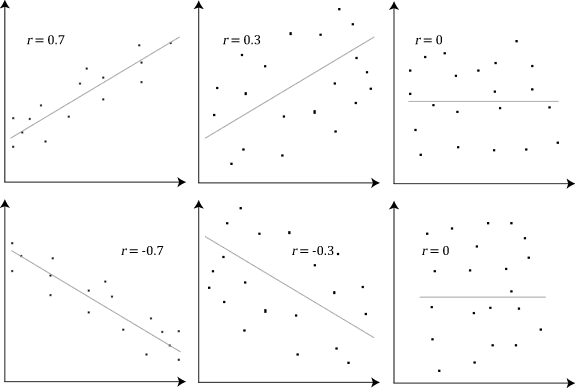

Vamos calcular nas próximas células a correlação de cada uma das nossas colunas com a variável resposta. Acompanhe:


In [ ]:
# Calculando a correlação de cada atributo (genes) com a variável resposta:
cor = data.apply(lambda x: x.corr(cls))
cor

In [ ]:
cls

Na célula anterior criamos uma variável *cor*, onde cada linha representa um gene e os valores correspondem a sua correlação com a variável resposta. 

Atributos que tenha uma correlação próxima de zero podem não ser importantes para criar o modelo de aprendizagem de máquina. 

Vamos tentar filtrar os nossos dados pegando apenas aqueles atributos que tenha uma correlação acima de 0.3 ou abaixo de -0.3.

In [ ]:
corabs = abs(cor) # coloca os valores de correlação em valores absolutos
corabs

In [ ]:
# selecionar os atributos que tenha uma correlação acima de 0.3 ou abaixo de -0.3
atrIdx = np.where(corabs >= 0.3)
data2 = data.iloc[:,atrIdx[0]]
data2



Quantos genes no total foram eliminados após este procedimento? _ _ _ _ _ _ _ _ 

In [ ]:
# Pegar os nomes dos genes que passaram no filtro da correlação
feature_names2 = feature_names[corabs >= 0.3]
feature_names2

Vamos criar o nosso classificador utilizando os dados filtrados e ver se modificou a sua acurácia.

In [ ]:
clf = svm.SVC(gamma="scale", C=10)
scores = cross_val_score(clf, data2, cls, cv=4)  
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

### Eliminando atributos altamente correlacionados

Quando você tem dois atributos que possuem alta correlação, eles são linearmente dependentes e, portanto, possuem influência semelhante na geração do classificador. Então, quando encontramos dois atributos que possuem alta correlação, podemos eliminar um deles.

O código abaixo irá verificar a correlação par a par dos atributos e eliminar um dos atributos caso eles tenham uma correlação acima de 0,8. 

In [ ]:
# correlation
corr = data2.corr()

In [ ]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
  if columns[i]:
    for j in range(i+1, corr.shape[0]):
      if corr.iloc[i,j] >= 0.8:
        if columns[j]:
          columns[j] = False
selected_columns = data2.columns[columns]
data3 = data2[selected_columns]

In [ ]:
data3

Quantos genes no total foram eliminados após este procedimento? _ _ _ _ _ _ _ _ 

Vamos criar o nosso classificador utilizando os dados filtrados e ver se modificou a sua acurácia.

In [ ]:
clf = svm.SVC(gamma="scale", C=10)
scores = cross_val_score(clf, data3, cls, cv=4)  
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

In [ ]:
# Pegar os nomes dos genes que passaram no segundo filtro da correlação
feature_names3 = feature_names2[selected_columns]
feature_names3

## Método Wrapper

Neste método, utiliza-se a performance de um método supervisionado de aprendizagem de máquina (como acurácia) para avaliar se um determinado atributo merece ser incluído na análise ou não.

Alguns exemplos de métodos que utilizam a abordagem Wrapper seriam:

* *Forward Selection*: O procedimento inicia-se com um conjunto vazio (conjunto reduzido) de atributos. O atributo que melhor contribui na construção do modelo é adicionado ao conjunto reduzido. Nas iterações posteriores, o método novamente escolhe aquele atributo que melhor contribui na acurácia do modelo e o adiciona no conjunto reduzido.

<img src='https://miro.medium.com/max/2400/1*N105in3SvDixK_mbWpXFZg.png'>

* *Backward Elimination*: Contrário do forward selection, o procedimento inicia-se com um conjunto com todos os atributos. A cada iteração, o método retira do conjunto atributos que pior contribui na performance do modelo. Um outro nome para este método também é *Recursive Feature elimination*. 

<img src='https://miro.medium.com/max/2400/1*FrZouYQpASK0YJ1x81dNWw.png'>

* *Combinação do forward selection e backward elimination*: Os passos dos métodos forward selection e backward elimination podem ser combinados de forma que, em cada passo, verifica-se tanto a performance do modelo quando adiciona ou remove um atributo do conjunto.




Nesta prática utilizaremos a função *SequentialFeatureSelector* do pacote *mlxtend* para selecionarmos os atributos considerados importantes na análise.

In [ ]:
# Carregando as bibliotecas necessárias 
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [ ]:
#criando o modelo
model = svm.SVC(gamma="scale", C=10)

# Forward selection
sfs1 = SFS(model, 
           k_features=(1,10), # número de atributos a ser selecionado. Colocar "best" para selecionar a melhor combinação.
           forward=True,      # False para backward
           floating=False,    # True para combinar forward e backward
           verbose=2,
           scoring='accuracy',# métrica para medir a performance
           cv=4,              # k-fold cross-validation
           n_jobs=4           # número de processadores
           )

# executando o forward selection
sfs1 = sfs1.fit(data3,  # dados filtrados 
                cls,    # variável resposta
                custom_feature_names=list(feature_names3) # nomes dos atributos
                )

In [ ]:
# Detalhes de cada iteração 
sfs1.subsets_


In [ ]:
# Gráfico da performance do classificador ao longo da iteração
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')

plt.ylim([0.8, 1.01])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [ ]:
print('Selected features:', sfs1.k_feature_names_)

Neste procedimento foram selecionados _ _ _ _ _ atributos.

Vamos verificar a performance do nosso classificador utilizando apenas os atributos selecionados:

In [ ]:
data4 = data3.iloc[:, list(sfs1.k_feature_idx_)]
# Verificando a performance do classificador
clf = svm.SVC(gamma="scale", C=10)
scores = cross_val_score(clf, data4, cls, cv=4)  
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

## Referência dos dados
* Shipp et al., <b>Diffuse Large B-Cell Lymphoma Outcome Prediction by Gene Expression Profiling and Supervised Machine Learning </b>, Nature Medicine January 2002 Volume 8 Number 1 pp 68 - 74. Published: 2001.12.31

* scikit-learn - Feature Selection: https://scikit-learn.org/stable/modules/feature_selection.html

* Feature Selection For Machine Learning in Python: https://machinelearningmastery.com/feature-selection-machine-learning-python/

* Beginner's Guide to Feature Selection in Python: https://www.datacamp.com/community/tutorials/feature-selection-python

* Feature Selection with sklearn and Pandas: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

* mlxtend: http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/#sequential-feature-selector


## Extra 1 (Heatmaps)

Em dados de expressão gênica, é comum realizarmos um heatmap indicando quais genes estão diferencialmente expressos entre amostras de características constrantes. O código a seguir mostra como podemos fazer isso: 

In [ ]:
# Selecionando os genes que possuem uma correlação acima de 0.5
atrIdx = np.where(cor >= 0.5)
data5 = data.iloc[:,atrIdx[0]]

# Selecionando os nomes dos genes que possuem a correlação acima de 0.5
feature_names5 = feature_names[cor >= 0.5]

data5

In [ ]:
# Transformando os dados de expressão utilizando o z-score
# para tornar os dados comparáveis.
data5z = data5.copy()
for col in data5.columns:
    data5z[col] = (data5[col] - data5[col].mean())/data5[col].std(ddof=0)

data5z

In [ ]:
# Plotando o heatmap desses genes
heat_map = sns.heatmap(data5z, cmap="RdBu")
plt.show()

feature_names5

In [ ]:
# Realizando o mesmo procedimento, mas para genes que possuem correlação abaixo de -0.5
atrIdx = np.where(cor <= -0.5)
data5 = data.iloc[:,atrIdx[0]]
feature_names5 = feature_names[cor <= -0.5]

data5z = data5.copy()
for col in data5.columns:
    data5z[col] = (data5[col] - data5[col].mean())/data5[col].std(ddof=0)

data5z
heat_map = sns.heatmap(data5z, cmap="RdBu")
plt.show()

feature_names5

## Extra 2 (Heatmap de correlação com agrupador hierárquico)

A célula a seguir mostra como podemos criar um heatmap de dados de correlação entre pares de atributos. (fonte: https://www.kaggle.com/sgalella/correlation-heatmaps-with-hierarchical-clustering)

In [ ]:
sns.clustermap(corr, method="complete", cmap='RdBu', 
               annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(15,12));